# Malaria Affected Cells Detection using CNN with pytorch

Links followed : https://lhncbc.nlm.nih.gov/publication/pub9932

## About the Dataset

The dataset contains 2 folders

Infected & Uninfected data and a total of 27,558 images.



# Import libraries 
numpy, pandas, and matplotlib & pytorch as the base libraries

jovian for submitting the notebook


In [5]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet# Uncomment and run the commands below if imports fail
# !conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet

ERROR: osmnx 0.14.1 has requirement geopandas>=0.7, but you'll have geopandas 0.6.3 which is incompatible.
ERROR: hypertools 0.6.2 has requirement scikit-learn<0.22,>=0.19.1, but you'll have scikit-learn 0.23.1 which is incompatible.


In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
project_name='05-assignment-malaria-cells-cnn'

# Preparing the Data

Downloading the dataset and creating PyTorch datasets to load the data.

## data source : 
Dataset: ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip


In [3]:
# Dowload the dataset
dataset_url = "ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip"
download_url(dataset_url, '.')

In [4]:
import jovian
jovian.commit(filename=project_name, environment=None)


ModuleNotFoundError: No module named 'jovian'

In [6]:
from zipfile import ZipFile
with ZipFile('./cell_images.zip', 'r') as zipobj:
    zipobj.extractall(path='./data')


In [7]:
!ls -al data/cell_images

total 2128
drwxr-xr-x 4 root root    4096 Jun 27 06:03 .
drwxr-xr-x 3 root root    4096 Jun 27 06:03 ..
drwxr-xr-x 2 root root 1097728 Jun 27 06:03 Parasitized
drwxr-xr-x 2 root root 1073152 Jun 27 06:03 Uninfected


In [8]:
import glob
base_dir = os.path.join('./data/cell_images')
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
print (len(infected_files), len(healthy_files))


13779 13779


## Data view & Dataframe
It looks like we have a balanced dataset with 13,779 malaria and 13,779 non-malaria (uninfected) cell images. 
Build a data frame from this, which we will use when we start building our datasets.


In [9]:
datafiles = infected_files + healthy_files
print (len(datafiles))
#print(datafiles[10])

27558


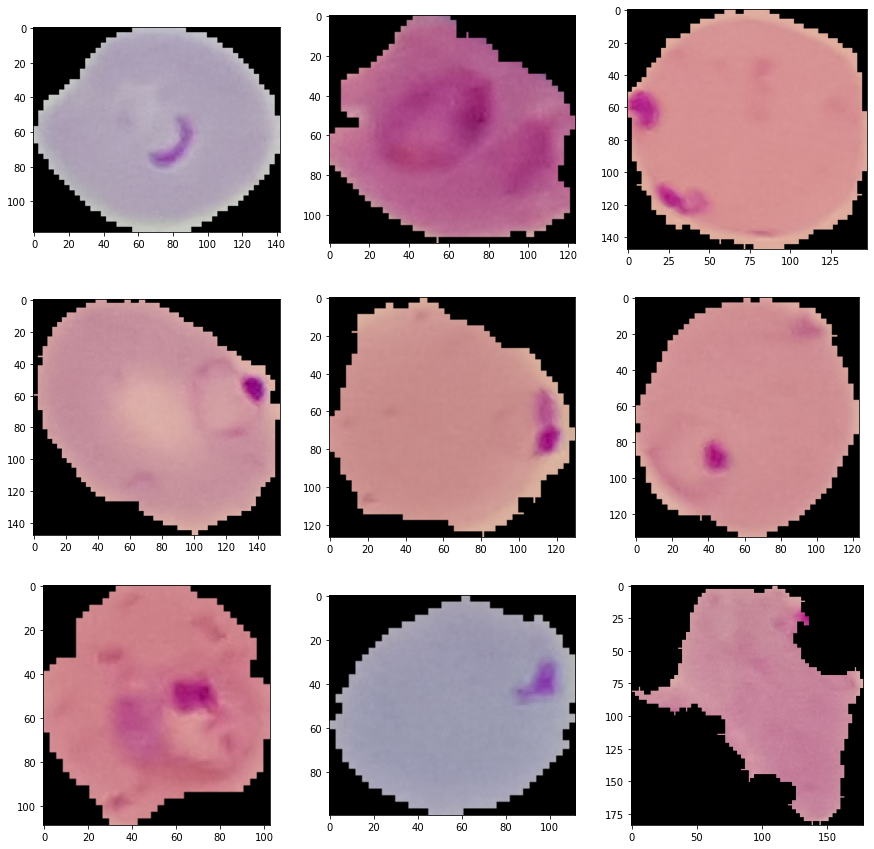

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
#im_list

for i in range(9):
    img = plt.imread(datafiles[i])
    ax=axes[i//3,i%3]
    ax.imshow(img) 

## Challange : 
1. convert images into tensors
2. reshaping the images 

In [11]:
from PIL import Image
from torchvision.transforms import ToTensor
img_path=datafiles[7]
print (img_path)
image = Image.open(img_path)
image = ToTensor()(image) # unsqueeze to add artificial first dimension
type(image)

./data/cell_images/Parasitized/C182P143NThinF_IMG_20151201_172216_cell_144.png


torch.Tensor

In [12]:
image.shape

torch.Size([3, 100, 112])

In [13]:
#spiting the data into train and validation
torch.manual_seed(43)
val_size = int (len(datafiles) * 0.2)
train_size = len(datafiles) - val_size
print (train_size , val_size)

22047 5511


In [14]:
batch_size=128


In [15]:
# Data transforms (normalization & data augmentation)
stats = [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]
#stats = ([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
#train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
#                         tt.RandomHorizontalFlip(), 
#                         tt.ToTensor(), 
#                         tt.Normalize(*stats,inplace=True)])
#valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])
train_tfms = tt.Compose([tt.Resize((120,120)),
    tt.ColorJitter(0.05),
    tt.RandomHorizontalFlip(),
    tt.RandomVerticalFlip(),
    tt.RandomRotation(20),
    tt.ToTensor(),
    tt.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

In [16]:
# PyTorch datasets
dataset_ds = ImageFolder(base_dir, train_tfms)
train_ds, valid_ds = random_split(dataset_ds, [train_size, val_size])
len(train_ds), len(valid_ds)

(22047, 5511)

In [17]:
#train_loader = DataLoader(train_ds, batch_size=batch_size)
#val_loader = DataLoader(val_ds, batch_size=batch_size)
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2,num_workers=3, pin_memory=True)
print("Images in train set: {}\nImages in validation set: {}".format(len(train_dl), len(valid_dl)))

Images in train set: 173
Images in validation set: 22


In [18]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

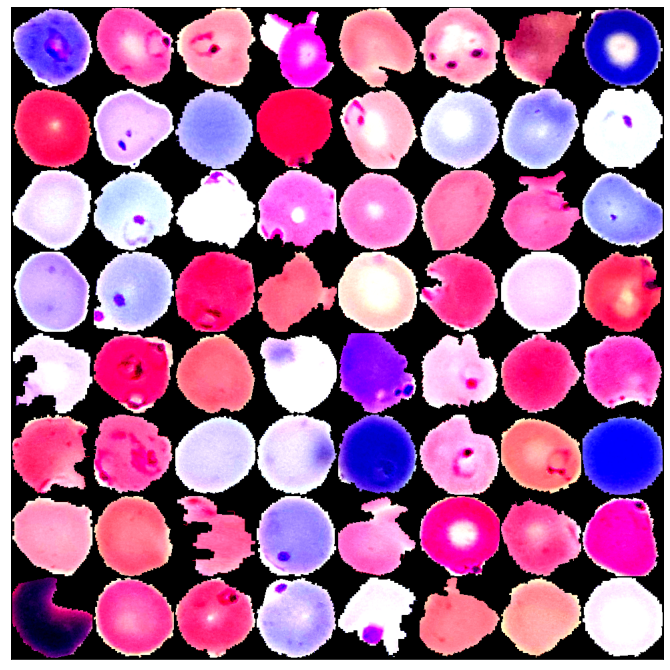

In [19]:
#images, labels = next(iter(train_loader))
#print (image,labels)
#fig = plt.figure(figsize=(25, 15))

show_batch(train_dl)


In [20]:
classes=['infected','uninfected']

## Using a GPU
Function to support GPU if possible

In [21]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
device = get_default_device()
device

device(type='cuda')

our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available).

In [23]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Training and Validation

In [24]:
 def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
 def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum().float()
    TN = ((~prob) & (~label)).sum().float()
    FP = (prob & (~label)).sum().float()
    FN = ((~prob) & label).sum().float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [25]:
x = np.array([5,6,5,4,5,6])
y = np.array([6,5,4,5,6,6])
value = (x & y).sum()
value

26

In [26]:

class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        #print ("batch ", batch)
        #print(len(targets), len(images))
        #loss = 0
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        #score = F_score(out, targets)
        acc = accuracy(out,targets)
        return {'val_loss': loss.detach(), 'val_acc': acc }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_acc'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [27]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=2, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU()]
    if pool: layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

class ImageClassificationBase(MultilabelImageClassificationBase):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self):
        super().__init__()
        #self.conv1 = conv_block(in_channels, 64)
        self.layer1 = conv_block(3, 16,True)
        self.layer2 = conv_block(16,32,True)
        self.layer3 = conv_block(32, 64,True)
        self.fc1 = nn.Linear(64*15*15, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)
        self.drop = nn.Dropout2d(0.2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)    
        out = self.fc1(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.fc3(out)
        return out
    

In [28]:
model = ImageClassificationBase()
model.to(device)


ImageClassificationBase(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=14400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out

In [29]:
from tqdm.notebook import tqdm

In [30]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [31]:
num_epochs = 2
opt_func = torch.optim.Adam
learning_rate = 1e-2

In [32]:

history = fit(num_epochs, learning_rate, model, train_dl, valid_dl, opt_func)


Epoch [0], train_loss: 2.0176, val_loss: 0.4296, val_score: 0.8044



Epoch [1], train_loss: 0.2869, val_loss: 0.1976, val_score: 0.9325


In [33]:
evaluate(model, valid_dl)

{'val_loss': 0.19549567997455597, 'val_acc': 0.9325165152549744}

In [34]:
num_epochs = 5
learning_rate = 1e-3
history += fit(num_epochs, learning_rate, model, train_dl, valid_dl, opt_func)


Epoch [0], train_loss: 0.1943, val_loss: 0.1691, val_score: 0.9433



Epoch [1], train_loss: 0.1750, val_loss: 0.1765, val_score: 0.9444



Epoch [2], train_loss: 0.1615, val_loss: 0.1528, val_score: 0.9534



Epoch [3], train_loss: 0.1558, val_loss: 0.1421, val_score: 0.9536



Epoch [4], train_loss: 0.1484, val_loss: 0.1328, val_score: 0.9572


In [35]:
num_epochs = 5
learning_rate = 1e-4
history += fit(num_epochs, learning_rate, model, train_dl, valid_dl, opt_func)


Epoch [0], train_loss: 0.1393, val_loss: 0.1298, val_score: 0.9564



Epoch [1], train_loss: 0.1349, val_loss: 0.1293, val_score: 0.9585



Epoch [2], train_loss: 0.1318, val_loss: 0.1269, val_score: 0.9605



Epoch [3], train_loss: 0.1319, val_loss: 0.1249, val_score: 0.9591



Epoch [4], train_loss: 0.1319, val_loss: 0.1231, val_score: 0.9582


## Visualizing the result

### Accuracy 

In [36]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

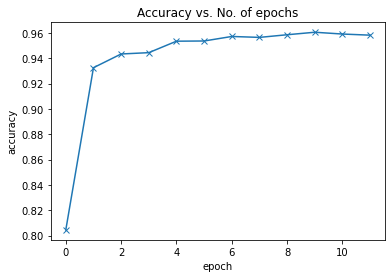

In [37]:
plot_accuracies(history)

### Loss

In [38]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

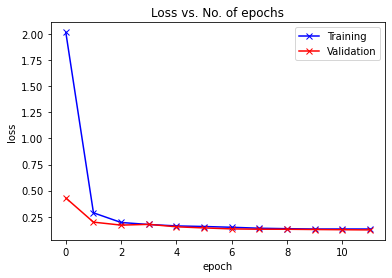

In [39]:
plot_losses(history)

In [153]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

## Sava & Commit

In [47]:
torch.save(model.state_dict(), 'malaria-cells-cnn.pth')

In [40]:
!pip install jovian --upgrade --quiet

In [44]:
import jovian

In [51]:
#jovin.reset()
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'])

[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Metrics logged.


In [52]:
jovian.commit(project=project_name, environment=None, outputs=['malaria-cells-cnn.pth'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/vikrantchoudhary/05-assignment-malaria-cells-cnn


<IPython.core.display.Javascript object>

## Refrences used :

Refrences notebook : https://jovian.ml/aakashns/05b-cifar10-resnet-live

Refrences :

1. https://opensource.com/article/19/4/detecting-malaria-deep-learning (using tensorflow2.0)

2. https://lhncbc.nlm.nih.gov/publication/pub9932 (original link for documentation & dataset)

3. https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce (to understsand image tranformation)

 